In [121]:
# DEVOIR 1 - Codes (Version 2)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap
from sklearn.neighbors import KNeighborsClassifier
sns.set(rc={'figure.figsize':(12,8)})

from skimage.morphology import skeletonize
from skimage.transform import hough_line, hough_line_peaks, hough_circle, hough_circle_peaks

In [122]:
#########################################################
###################   ALGORITHMES  ######################
#########################################################

# Fonction qui permet de calculer l'exactitude de l'algorithme (en %)
# Fonction de perte utilisée: erreur 0-1

# y1: y_train
# y2: y_valid ou y_test
# y_hat1: prédictions de y_train
# y_hat2: prédictions de y_test

# Retourne: un tuple contenant la précision sur les données d'entraînement
# ainsi que la précision sur les données de validation/de test
def calculate_accuracy(y1, y2, y_hat1, y_hat2):
    error_1 = 0.0
    error_2 = 0.0
    
    # Erreur d'entraînement
    for i in range(len(y1)):
        if y1[i] != y_hat1[i]:
            error_1 = error_1 + 1.0
        
    error_1 = (error_1 / len(y1))*100
    
    # Erreur de validation/de test
    for i in range(len(y2)):
        if y2[i] != y_hat2[i]:
            error_2 = error_2 + 1.0
    
    error_2 = (error_2 / len(y2))*100
    
    return(100-error_1, 100-error_2)

In [1]:
# Mesures de similarité

# Distance euclidienne (TP4)
def l2(x, y):
    return np.sum(abs(x - y) ** 2) ** (1/2)


# Similarité MNIST

# Alpha: Détermine le poids accordé à la détection de lignes versus la détection de cercles
# i.e. distance totale = alpha * distance_lignes + (1-alpha) * distance_cercles

# Nb_angles: Nombre d'angles testés pour la détection de lignes
# Un nombre trop grand d'angles peut détecter de fausses lignes, mais
# un nombre trop petit d'angles peut ne pas détecter des lignes importantes

# Tested_R: Rayons de cercles testés lors de la recherche de cercles
# Inclure des cercles trop petits peut nuire l'algorithme en négligeant les plus grands cercles
# moins complets que les petits cercles
def dissimilarity_mnist(x, y, alpha=0.5, nb_angles = 180, tested_R = [2,3,4,5,6,7,8,9,10]):
    
    # Réduire l'image à son squelette (segment d'épaisseur 1)
    img1 = skeletonize(x.reshape((28,28)))
    img2 = skeletonize(y.reshape((28,28)))  
    
    # Détection de lignes, avec l'accumulateur des lignes stockés dans h1 et h2
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, nb_angles, endpoint=False)    
    h1, theta1, d1 = hough_line(img1, theta = tested_angles) 
    h2, theta2, d2 = hough_line(img2, theta = tested_angles)    
    
    # Détection de cercles, avec l'accumulateur des cercles dans H1_c et H2_c
    H1_c = hough_circle(img1, tested_R)
    H2_c = hough_circle(img2, tested_R)
    
    # Normaliser les valeurs entre 0 et 255
    h1 *= int(255.0/h1.max())
    h2 *= int(255.0/h2.max())
    
    H1_c *= int(255.0/H1_c.max())
    H2_c *= int(255.0/H2_c.max())
    
    return alpha * l2(h1.astype(np.int64),h2.astype(np.int64)) + (1-alpha) * l2(H1_c.astype(np.int64), H2_c.astype(np.int64))

# Similarité ADULT

# Weight: ajuste les calculs de similarité pour chaque attribut en
# ajoutant ou enlevant plus de poids dépendant la situation.

# Alpha: calcul de similarité entre deux individus pour chaque attribut
# Pour un attribut catégorique: 0 ou 1
# Pour un attribut numérique: [0,1]

# Epsilon: Le threshold (seuil) pour déterminer la valeur d'alpha numérique
# Notez que lorsque epsilon = 0, cela indique que c'est un attribut catégorique.

def dissimilarity_adult(array_1, array_2):
    weight = np.array([1,2,0,0,1.5,0.5,2,0.5,1,0.75,0,0,1.5,1])
    epsilon = np.array([10,0,0,0,5,0,0,0,0,0,0,0,10,0])
    dissimilarity = 0

    for i in range(weight.shape[0]):
        alpha = 0
        if epsilon[i] == 0:
            # Lorsque les deux catégories sont différents
            if array_1[i] != array_2[i]:
                alpha = 1
                dissimilarity = dissimilarity + weight[i] * alpha
        else:
            difference = abs(array_1[i] - array_2[i])
            # Lorsque la différence dépasse le seuil
            if difference < epsilon[i]:
                alpha = float(difference)/epsilon
            else:
                alpha = 1
            dissimilarity = dissimilarity + weight[i] * alpha
                
                
    return dissimilarity

# Matrice de dissimilarité
def get_dissimilarity_matrix(dist, X, Y):
    diss_matrix = np.zeros((X.shape[0], Y.shape[0]))
    
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            diss_matrix[i,j] = dist(X[i], Y[j])
            
        if (i + 1) % 500 == 0:
            print(f'Itération {i + 1} terminée!') 
        if (i + 1) == X.shape[0]:
            print(f'Fin du calcul de la matrice')
            
    return diss_matrix

# Génération de la matrice de dissimilarité

# x et y: les features d'entraînement/de validation/de test
def generate_matrix(dist, X, Y=None):
    Y = X if Y is None else Y
    diss_matrix = get_dissimilarity_matrix(dist, X, Y)
    print(f'Dimension de la matrice: {diss_matrix.shape}')
    return diss_matrix

In [124]:
#########################################################
#######################   ADULT  ########################
#########################################################

# NOTE: Pour MNIST, on compare la précision avec la distance euclidienne. Étant
# donné que ADULT contient des données catégorielles, nous avons décidé de comparer
# notre performance des cinq algorithmes avec la précision obtenue dans la démo 2
# qui est environ de 81,0% de précision par kNN.

adult = pd.read_csv("adult.csv")
# On enlève les rangées avec les données manquantes. On travaille avec les données
# avec aucun point d'interrogation.
adult = adult[(adult != '?').all(axis = 1)]

# Échantillonnage des données ADULT

n_total = 7000
adult = adult.head(n_total)
y = adult['income']
adult = adult.drop(['income'], axis = 1)

x_trainval, x_test, y_trainval, y_test = train_test_split(adult, y, test_size = (1/7), stratify=y, random_state=0)
x_train, x_valid, y_train, y_valid = train_test_split(x_trainval, y_trainval, test_size = (1/6), random_state=0)

x_trainval = x_trainval.values
x_train = x_train.values
x_valid = x_valid.values
x_test = x_test.values

y_trainval = y_trainval.replace({'<=50K': 0, '>50K': 1}).values
y_train = y_train.replace({'<=50K': 0, '>50K': 1}).values
y_valid = y_valid.replace({'<=50K': 0, '>50K': 1}).values
y_test = y_test.replace({'<=50K': 0, '>50K': 1}).values

print(x_trainval.shape)
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(6000, 14)
(5000, 14)
(1000, 14)
(1000, 14)


In [125]:
print(f'Nombre de personnes avec salaire <= 50K: {np.count_nonzero(y_test == 0)}')

y_train_majority = np.zeros(len(y_train))
y_test_majority = np.zeros(len(y_test))

acc_majority = calculate_accuracy(y_train, y_test, y_train_majority, y_test_majority)

print(f'\nTEST DE MAJORITÉ:')
print(f'Précision sur les données de test: {acc_majority[1]}%')

Nombre de personnes avec salaire <= 50K: 755

TEST DE MAJORITÉ:
Précision sur les données de test: 75.5%


In [ ]:
# MATRICE DE DISSIMILARITÉ ADULT
print('\nMATRICE DE DISSIMILARITÉ ADULT (Apprentissage)') # 5000 x 5000
mnist_diss_trainval = generate_matrix(dissimilarity_adult, x_trainval)

print('\nMATRICE DE DISSIMILARITÉ ADULT (Entraînement)')  # 4000 x 4000
mnist_diss_train = generate_matrix(dissimilarity_adult, x_train)

print('\nMATRICE DE DISSIMILARITÉ ADULT (Validation)')    # 1000 x 4000
mnist_diss_valid = generate_matrix(dissimilarity_adult, x_valid, x_train)

print('\nMATRICE DE DISSIMILARITÉ ADULT (Test)')          # 1000 x 5000
mnist_diss_test = generate_matrix(dissimilarity_adult, x_test, x_trainval)

In [21]:
# KMédoïdes
def predict_kmedoids(initial_medoids, diss_train, diss_test):
    kmedoids_instance = kmedoids(diss_train, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    kmedoids_train = kmedoids_instance.predict(diss_train)
    kmedoids_test = kmedoids_instance.predict(diss_test)
    
    return(kmedoids_train, kmedoids_test)

In [35]:
# Partition Binaire
def agglomerative_clustering_predict(agglomerative_clustering, dissimilarity_matrix):
    average_dissimilarity = list()
    for i in range(agglomerative_clustering.n_clusters):
        ith_clusters_dissimilarity = dissimilarity_matrix[:, np.where(agglomerative_clustering.labels_==i)[0]]
        average_dissimilarity.append(ith_clusters_dissimilarity.mean(axis=1))
    return np.argmin(np.stack(average_dissimilarity), axis=0)

def predict_agglo(cluster, diss_train, diss_test):
    agglomerative_clustering = AgglomerativeClustering(n_clusters=cluster, affinity='precomputed', linkage='average')
    agglomerative_clustering.fit(diss_train)

    agglo_train = agglomerative_clustering_predict(agglomerative_clustering, diss_train)
    agglo_test = agglomerative_clustering_predict(agglomerative_clustering, diss_test)
    
    return(agglo_train, agglo_test)

In [51]:
# kNN
# train, test peuvent être soit x_train/x_test ou les matrices de dissimilarité
def predict_knn(neighbors, train, test, y_train, is_matrix):
    if is_matrix:
        knn = KNeighborsClassifier(n_neighbors=neighbors, metric='precomputed', algorithm='brute')
    else:
        knn = KNeighborsClassifier(n_neighbors=neighbors)
    
    knn.fit(train, y_train)
    knn_train = knn.predict(train)
    knn_test = knn.predict(test)
    
    return(knn_train, knn_test)

In [52]:
# PCoA
def predict_pcoa(component, diss_train, diss_test, neighbors, y_train):
    pcoa = KernelPCA(n_components = component, kernel='precomputed')
    pcoa_train = pcoa.fit_transform(-.5*diss_train**2)
    pcoa_test = pcoa.transform(-.5*diss_test**2)
    
    return predict_knn(neighbors, pcoa_train, pcoa_test, y_train, False)

In [62]:
# Isomap
def predict_isomap(component, diss_train, diss_test, neighbors, y_train):
    isomap = Isomap(n_components=components[i], n_neighbors=2, metric='precomputed')
    isomap_train = isomap.fit_transform(diss_train)
    isomap_test = isomap.transform(diss_test)
    
    return predict_knn(neighbors, isomap_train, isomap_test, y_train, False)

In [70]:
#########################################################
#######################   MNIST  ########################
#########################################################

# Échantillonnage des données MNIST

# Les données d'apprentissage est composée des données de train et de valid.
# Lorsqu'un algorithme n'a pas d'hyperparamètres à tester, on apprend directement
# avec x_trainval.

# Lorsqu'il y a présence des hyperparamètres:
# Pour chaque valeur d'hyperparamètre:
# 1. Apprendre sur x_train
# 2. Calculer la précision par rapport aux prédictions sur x_valid
# 3. Trouver le meilleur hyperparamètre

# Pour la prédiction:
# 1. Apprendre sur x_trainval avec l'hyperparamètre à valeur optimale.
# 2. Prédire sur x_test

n_trainval = 5000
mnist_trainval = pd.read_csv('mnist_train.csv')
mnist_trainval = mnist_trainval.head(5000)
x_trainval = mnist_trainval.drop('label', axis = 1).values
y_trainval = mnist_trainval.loc[:, 'label'].values

x_train, x_valid, y_train, y_valid = train_test_split(x_trainval, y_trainval, test_size=(1/5), random_state=0)

n_test = 1000
mnist_test = pd.read_csv('mnist_test.csv')
mnist_test = mnist_test.head(n_test)
x_test = mnist_test.drop('label', axis = 1).values
y_test = mnist_test.loc[:, 'label'].values

y_valid

array([1, 2, 3, 6, 7, 6, 9, 3, 7, 1, 1, 4, 0, 8, 4, 5, 7, 7, 3, 4, 2, 2,
       4, 8, 1, 1, 2, 6, 8, 0, 9, 6, 1, 6, 5, 8, 0, 2, 1, 1, 5, 2, 7, 0,
       7, 5, 3, 7, 5, 4, 1, 3, 1, 1, 9, 0, 1, 1, 9, 1, 5, 7, 8, 3, 7, 0,
       7, 3, 9, 4, 2, 6, 2, 9, 7, 7, 1, 5, 4, 4, 3, 2, 9, 9, 2, 8, 4, 8,
       5, 9, 8, 5, 4, 5, 3, 7, 7, 6, 1, 6, 0, 4, 4, 4, 1, 6, 5, 5, 2, 6,
       1, 3, 9, 9, 1, 2, 0, 3, 2, 3, 7, 9, 3, 8, 9, 7, 7, 9, 8, 3, 1, 7,
       4, 6, 9, 6, 8, 1, 1, 6, 9, 4, 1, 7, 5, 5, 1, 1, 8, 0, 3, 3, 4, 6,
       3, 6, 7, 9, 7, 9, 7, 3, 5, 0, 8, 0, 7, 6, 1, 5, 9, 1, 1, 7, 4, 3,
       2, 0, 6, 1, 9, 3, 6, 8, 6, 6, 2, 3, 4, 6, 9, 3, 3, 8, 3, 1, 3, 7,
       7, 6, 1, 6, 7, 8, 5, 8, 6, 5, 5, 4, 8, 8, 0, 0, 9, 6, 8, 5, 8, 9,
       4, 1, 8, 1, 9, 8, 9, 3, 6, 5, 6, 6, 5, 6, 1, 8, 3, 1, 3, 9, 9, 8,
       9, 3, 2, 3, 7, 5, 8, 7, 1, 3, 5, 6, 4, 5, 5, 3, 5, 1, 3, 5, 1, 7,
       8, 2, 8, 1, 7, 0, 1, 4, 3, 9, 5, 7, 2, 7, 1, 9, 1, 2, 3, 1, 3, 2,
       2, 0, 8, 6, 5, 9, 4, 7, 5, 7, 1, 0, 7, 1, 5,

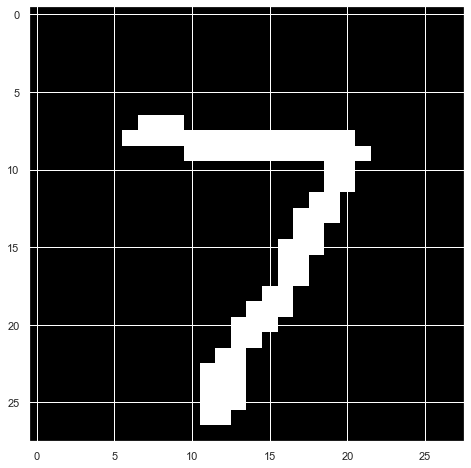

In [5]:
# NETTOYAGE DES DONNÉES (convertir les pixels de 0 à 255, à avoir uniquement
# des chiffres binaires (0 ou 1)) (TP1)
def clean_data_MNIST(x):
    for i in range(len(x)):
        for j in range(len(x[0])):
            if x[i][j] != 0:
                x[i][j] = round(int(x[i][j])/255.0)
    return x

x_trainval = clean_data_MNIST(x_trainval)
x_train = clean_data_MNIST(x_train)
x_valid = clean_data_MNIST(x_valid)
x_test = clean_data_MNIST(x_test)

image = x_test[0]
matrix_image = np.reshape(image, (28,28))
plt.imshow(matrix_image, cmap='gray')
plt.show()

In [6]:
# TEST DE MAJORITÉ
print('MNIST')
print('Dans les données du test...')
for i in range(0,10):
    print(f'Nombre d\'occurences du chiffre {i}: {np.count_nonzero(y_test == i)}')
    
# Chiffre majoritaire: 
y_train_majority = np.full(len(y_train), 1)
y_test_majority = np.full(len(y_test), 1)
acc_majority = calculate_accuracy(y_train, y_test, y_train_majority, y_test_majority)
print(f'\nTEST DE MAJORITÉ:')
print(f'Précision sur les données de test: {acc_majority[1]}%')

# L'objectif est de battre cette précision.
# Précision de 12.60%

MNIST
Dans les données du test...
Nombre d'occurences du chiffre 0: 85
Nombre d'occurences du chiffre 1: 126
Nombre d'occurences du chiffre 2: 116
Nombre d'occurences du chiffre 3: 107
Nombre d'occurences du chiffre 4: 110
Nombre d'occurences du chiffre 5: 87
Nombre d'occurences du chiffre 6: 87
Nombre d'occurences du chiffre 7: 99
Nombre d'occurences du chiffre 8: 89
Nombre d'occurences du chiffre 9: 94

TEST DE MAJORITÉ:
Précision sur les données de test: 12.599999999999994%


In [7]:
# MATRICE DE DISSIMILARITÉ EUCLIDIENNE
print('\nMATRICE DE DISSIMILARITÉ EUCLIDIENNE (Apprentissage)') # 5000 x 5000
mnist_diss_trainval = generate_matrix(l2, x_trainval)

print('\nMATRICE DE DISSIMILARITÉ EUCLIDIENNE (Entraînement)')  # 4000 x 4000
mnist_diss_train = generate_matrix(l2, x_train)

print('\nMATRICE DE DISSIMILARITÉ EUCLIDIENNE (Validation)')    # 1000 x 4000
mnist_diss_valid = generate_matrix(l2, x_valid, x_train)

print('\nMATRICE DE DISSIMILARITÉ EUCLIDIENNE (Test)')          # 1000 x 5000
mnist_diss_test = generate_matrix(l2, x_test, x_trainval)


MATRICE DE DISSIMILARITÉ EUCLIDIENNE (Apprentissage)
Itération 500 terminée!
Itération 1000 terminée!
Itération 1500 terminée!
Itération 2000 terminée!
Itération 2500 terminée!
Itération 3000 terminée!
Itération 3500 terminée!
Itération 4000 terminée!
Itération 4500 terminée!
Itération 5000 terminée!
Fin du calcul de la matrice
Dimension de la matrice: (5000, 5000)

MATRICE DE DISSIMILARITÉ EUCLIDIENNE (Entraînement)
Itération 500 terminée!
Itération 1000 terminée!
Itération 1500 terminée!
Itération 2000 terminée!
Itération 2500 terminée!
Itération 3000 terminée!
Itération 3500 terminée!
Itération 4000 terminée!
Fin du calcul de la matrice
Dimension de la matrice: (4000, 4000)

MATRICE DE DISSIMILARITÉ EUCLIDIENNE (Validation)
Itération 500 terminée!
Itération 1000 terminée!
Fin du calcul de la matrice
Dimension de la matrice: (1000, 4000)

MATRICE DE DISSIMILARITÉ EUCLIDIENNE (Test)
Itération 500 terminée!
Itération 1000 terminée!
Fin du calcul de la matrice
Dimension de la matrice: 

In [26]:
# Algorithme 1: KMédoïdes
print('\nALGORITHME 1: KMédoïdes')
mnist_kmedoids = predict_kmedoids([0,1,2,3,4,5,6,7,8,9], mnist_diss_trainval, mnist_diss_test)
acc_kmedoids = calculate_accuracy(y_trainval, y_test, mnist_kmedoids[0], mnist_kmedoids[1])

print(f'Précision sur les données d\'apprentissage: {acc_kmedoids[0]}%')
print(f'Précision sur les données de test: {acc_kmedoids[1]}%')


ALGORITHME 1: KMédoïdes
Précision sur les données d'apprentissage: 19.64%
Précision sur les données de test: 17.60000000000001%


In [39]:
# Algorithme 2: Partition Binaire
print('\nALGORITHME 2: Partition Binaire')
mnist_agglo = predict_agglo(10, mnist_diss_trainval, mnist_diss_test)
acc_agglo = calculate_accuracy(y_trainval, y_test, mnist_agglo[0], mnist_agglo[1])

print(f'Précision sur les données d\'apprentissage: {acc_agglo[0]}%')
print(f'Précision sur les données de test: {acc_agglo[1]}%')


ALGORITHME 2: Partition Binaire
Précision sur les données d'apprentissage: 1.6200000000000045%
Précision sur les données de test: 2.4000000000000057%



ALGORITHME 3 kNN


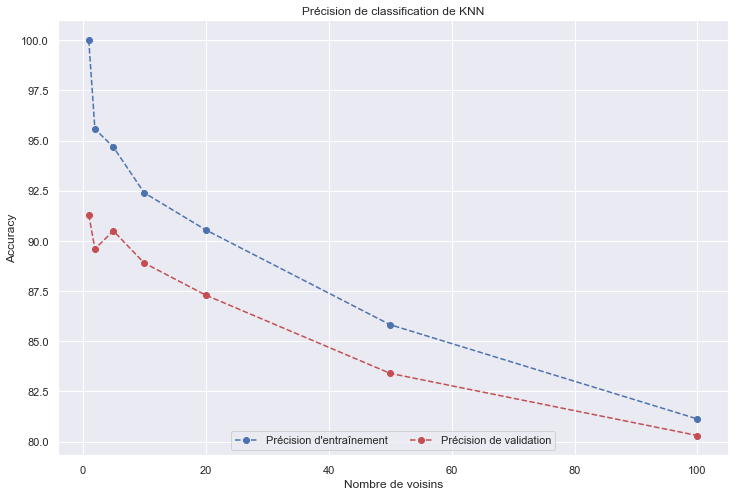

In [65]:
# Algorithme 3: KNN
print('\nALGORITHME 3 kNN')
voisins = np.array([1, 2, 5, 10, 20, 50, 100])
error_train = np.zeros(len(voisins))
error_valid = np.zeros(len(voisins))

for i in range(len(voisins)):
    mnist_knn = predict_knn(voisins[i], mnist_diss_train, mnist_diss_valid, y_train, True)
    acc_knn = calculate_accuracy(y_train, y_valid, mnist_knn[0], mnist_knn[1])
    
    error_train[i] = acc_knn[0]
    error_valid[i] = acc_knn[1]

plt.plot(voisins, error_train, linestyle='--', marker='o', color='b', label = "Précision d'entraînement")
plt.plot(voisins, error_valid, linestyle='--', marker='o', color='r', label = "Précision de validation")
plt.legend(frameon=True, loc='lower center', ncol=2)
plt.xlabel('Nombre de voisins')
plt.ylabel('Accuracy')
plt.title('Précision de classification de KNN')
plt.grid(True)
plt.show()

In [54]:
mnist_knn = predict_knn(1, mnist_diss_trainval, mnist_diss_test, y_trainval, True)
acc_knn = calculate_accuracy(y_trainval, y_test, mnist_knn[0], mnist_knn[1])

print(f'Hyperparamètre choisi: 1 voisin')
print(f'Précision sur les données d\'apprentissage: {acc_knn[0]}%')
print(f'Précision sur les données de test: {acc_knn[1]}%')

Hyperparamètre choisi: 1 voisin
Précision sur les données d'apprentissage: 100.0%
Précision sur les données de test: 87.6%



ALGORITHME 4 PCoA


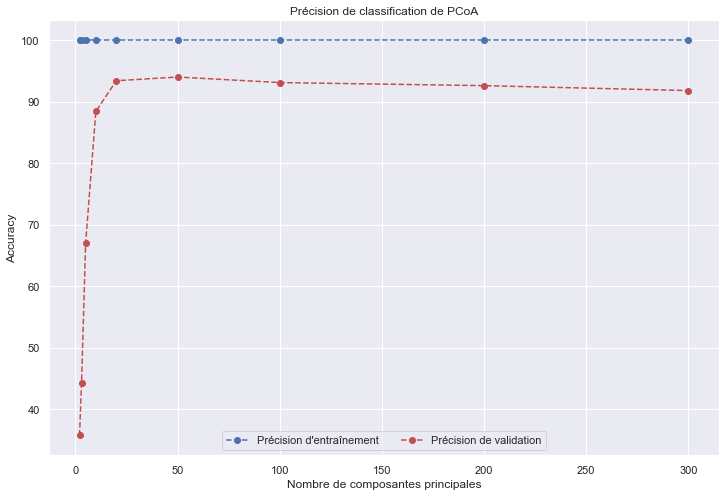

In [66]:
# Algorithme 4: PCoA
print('\nALGORITHME 4 PCoA')

components = np.array([2, 3, 5, 10, 20, 50, 100, 200, 300])
error_train = np.zeros(len(components))
error_valid = np.zeros(len(components))

for i in range(len(components)):
    mnist_pcoa = predict_pcoa(components[i], mnist_diss_train, mnist_diss_valid, 1, y_train)
    acc_pcoa = calculate_accuracy(y_train, y_valid, mnist_pcoa[0], mnist_pcoa[1])
    
    error_train[i] = acc_pcoa[0]
    error_valid[i] = acc_pcoa[1]

plt.plot(components, error_train, linestyle='--', marker='o', color='b', label = "Précision d'entraînement")
plt.plot(components, error_valid, linestyle='--', marker='o', color='r', label = "Précision de validation")
plt.legend(frameon=True, loc='lower center', ncol=2)
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Accuracy')
plt.title('Précision de classification de PCoA')
plt.grid(True)
plt.show()

In [67]:
mnist_pcoa = predict_pcoa(50, mnist_diss_trainval, mnist_diss_test, 1, y_trainval)
acc_pcoa = calculate_accuracy(y_trainval, y_test, mnist_pcoa[0], mnist_pcoa[1])

print(f'Hyperparamètre choisi: 50 composantes principales')
print(f'Précision sur les données d\'apprentissage: {acc_pcoa[0]}%')
print(f'Précision sur les données de test: {acc_pcoa[1]}%')

Hyperparamètre choisi: 50 composantes principales
Précision sur les données d'apprentissage: 100.0%
Précision sur les données de test: 92.0%



ALGORITHME 5 Isomap


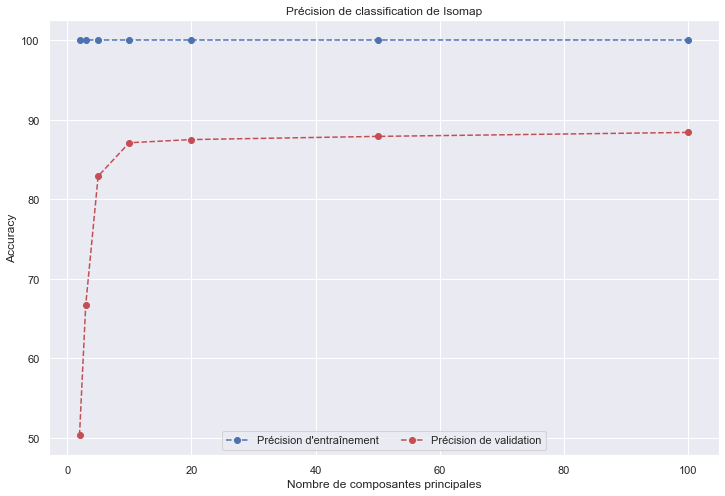

In [68]:
# Algorithme 5: Isomap
print('\nALGORITHME 5 Isomap')

components = np.array([2, 3, 5, 10, 20, 50, 100])
error_train = np.zeros(len(components))
error_valid = np.zeros(len(components))

for i in range(len(components)):
    mnist_isomap = predict_isomap(components[i], mnist_diss_train, mnist_diss_valid, 1, y_train)
    acc_isomap = calculate_accuracy(y_train, y_valid, mnist_isomap[0], mnist_isomap[1])
    
    error_train[i] = acc_isomap[0]
    error_valid[i] = acc_isomap[1]

plt.plot(components, error_train, linestyle='--', marker='o', color='b', label = "Précision d'entraînement")
plt.plot(components, error_valid, linestyle='--', marker='o', color='r', label = "Précision de validation")
plt.legend(frameon=True, loc='lower center', ncol=2)
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Accuracy')
plt.title('Précision de classification de Isomap')
plt.grid(True)
plt.show()

In [69]:
mnist_isomap = predict_isomap(50, mnist_diss_trainval, mnist_diss_test, 1, y_trainval)
acc_isomap = calculate_accuracy(y_trainval, y_test, mnist_isomap[0], mnist_isomap[1])

print(f'Hyperparamètre choisi: 50')
print(f'Précision sur les données d\'apprentissage: {acc_isomap[0]}%')
print(f'Précision sur les données de test: {acc_isomap[1]}%')

Hyperparamètre choisi: 50
Précision sur les données d'apprentissage: 100.0%
Précision sur les données de test: 85.3%


In [ ]:
# Anciens codes non utilisés pour l'instant

# Graphique des PCoA à 2 dimensions

#sns.set(rc={'figure.figsize':(12,8)})
#graph_train = sns.scatterplot(x = pcoa_train[:,0], y = pcoa_train[:, 1], hue = y_train, 
#                        palette = ['red', 'orange', 'gold', 'green', 'blue', 'purple', 'pink', 'brown', 'grey', 'black'])

#sns.set(rc={'figure.figsize':(12,8)})
#graph_test = sns.scatterplot(x = pcoa_test[:,0], y = pcoa_test[:, 1], hue = y_test, 
#                        palette = ['red', 'orange', 'gold', 'green', 'blue', 'purple', 'pink', 'brown', 'grey', 'black'])

# Isomap
#isomap = Isomap(n_components=2, n_neighbors=2, metric='precomputed')
#isomap_train = isomap.fit_transform(mnist_dissimilarity_train)
#isomap_test = isomap.transform(mnist_dissimilarity_test)

#import seaborn as sns
#sns.set(rc={'figure.figsize':(12,8)})
#graph_train = sns.scatterplot(x = isomap_train[:,0], y = isomap_train[:,1], hue = y_train, 
#                        palette = ['red', 'orange', 'gold', 'green', 'blue', 'purple', 'pink', 'brown', 'grey', 'black'])

#graph_test = sns.scatterplot(x = isomap_test[:,0], y = isomap_test[:,1], hue = y_test, 
#                        palette = ['red', 'orange', 'gold', 'green', 'blue', 'purple', 'pink', 'brown', 'grey', 'black'])